In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns
import glob
import os
import fnmatch

In [10]:
# Generals
ldp = '/Users/sol/Documents/LargeData/' # data folder
months=['January','February','March','April','May','June','July','August','September','October','November','December']

# reginoal domain
#ldom = np.array([[42.9, 48.4],[-126, -123]]) 
#ldom = np.array([[43, 48.5],[-129, -123]]) 
#ldom = np.array([[46.5,47.5],[-125.1,-124]])
ldom = np.array([[43, 48.5],[-129, -123]]) # 230, 237
lqin = np.array([[46, 48],[-125.8, -123.5]]) # 230, 237
# QIN domain
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 

In [3]:
#get bathymetry from ETOPO1
fn = ldp+'/Etopo/ETOPO1_Ice_g_gmt4.grd'
ds_topo = xr.open_dataset(fn)
ds_topo.close()
topo = ds_topo.z  #(10801, 21601)
topo2=topo.sel(y=slice(ldom[0,0],ldom[0,1]),x=slice(ldom[1,0],ldom[1,1]))
x = topo2.x  #21601
y = topo2.y   #10801
X,Y=np.meshgrid(x,y)

In [4]:
qin = xr.open_dataset(ldp+'/QIN/qin_mask.nc')
qin.close()
qin.coords['lon'] = np.mod(qin.coords['lon'] + 180,360) - 180
qin = qin.polygon_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
qin = qin.where(qin!=0,np.nan)

eez = xr.open_dataset(ldp+'/QIN/eez_mask.nc')
eez.close()
eez.coords['lon'] = np.mod(eez.coords['lon'] + 180,360) - 180
eez = eez.region_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
eez = eez.where(eez!=0,np.nan)

Xm, Ym = np.meshgrid(eez.lon,eez.lat)

# number of pixels in the mask
npx = qin.count(dim=['lat','lon']).values

In [5]:
fishes = ['Sablefish','Dungeness Crab','Hake','Lingcod','P. Halibut','Chinook','Coho','Steelhead']
var = ['thetao','o2']   
depth = ['surface','bottom']
ssps = ['ssp485','ssp585']
Trange = np.array([[4.72, 12.85],[5.36,11.72],[1.18,23.29],[6.56,13],[2.92,9.28],[3.49,11.65],[4.43,12.35],[6.38,16]])
O2range = np.array([[35.13, 298.72],[107.91,305.91],[111,169],[33.55,299.94],[55.67,319.55],[54.42,309.15],[58.94,316],[94.27,306.19]])
O2range = O2range/44.661  # conversion to ml/l
Deprange = np.array([[175, 1450],[41,90],[126,229],[18,60],[155,515],[43,172],[28,118],[22,95]])

In [57]:
def make_map(ds, dom, var, tit, depth=False, d1=0, d2=0):
    if var=='thetao':
        comap='YlOrRd'
        cd = 'b'
    else:
        comap='YlGnBu'
        cd = 'r'
        
    pers=['Dec-Feb','Jun-Aug']
    
    fig=plt.figure(figsize=(5,3),dpi=150)
    for i in range(2):
        ax = fig.add_subplot(1, 2, i+1, projection=ccrs.PlateCarree())
        ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
        ax.set_extent([dom[1,0],dom[1,1],dom[0,0],dom[0,1]],crs=ccrs.PlateCarree())
        if dom[1,1]-dom[1,0]>3:
            xt = range(int(np.ceil(dom[1,0])), int(np.floor(dom[1,1]))+1,3)
        else:
            xt = range(int(np.ceil(dom[1,0])), int(np.floor(dom[1,1]))+1,1)
        if dom[0,1]-dom[0,0]>3:
            yt = range(int(np.ceil(dom[0,0])), int(np.floor(dom[0,1]))+1,2)
        else:
            yt = range(int(np.ceil(dom[0,0])), int(np.floor(dom[0,1]))+1,1)
            
        ax.set_xticks(xt, crs=ccrs.PlateCarree())
        ax.set_yticks(yt, crs=ccrs.PlateCarree())
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        plt.grid(True, zorder=0,alpha=0.5)
        ax.set_aspect(1.5)
        plt.contour(X,Y,topo2,[-3000,-2000,-1000,-500,-200,-150, -100,-50],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.5)
        if depth==True:
            plt.contour(X,Y,topo2,[ -d2, -d1],colors=cd,linewidths=1, linestyles='solid', zorder=3, alpha=0.8)
        plt.plot(qbox[0,:],qbox[1,:],c='k',lw=2,zorder=5, alpha=0.7)

        vmi = int(np.floor(ds.min()))
        vmx = int(np.ceil(ds.max()))

        if i==0:
            plt.contourf(ds.lon, ds.lat, ds[0,:,:], cmap=comap, alpha=0.9, vmin=vmi, vmax=vmx)
        else:
            plt.contourf(ds.lon, ds.lat, ds[1,:,:], cmap=comap, alpha=0.9, vmin=vmi, vmax=vmx)

        if var=='thetao':
            if vmx-vmi>6:
                cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*range(vmi,vmx+1,4)])
            else:
                cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*range(vmi,vmx+1,2)])
        else:
            if vmx-vmi>1:
                cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*range(vmi,vmx+1,1)])
            else:
                cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*np.arange(vmi,vmx+0.2,0.25)])

        cb.ax.tick_params(labelsize='x-small')
        cb.set_label(label=tit, size='x-small', weight='bold')
        
        plt.text(dom[1,0]+0.1,dom[0,1]-0.1, pers[i],fontsize=8,backgroundcolor='w')
    plt.tight_layout(h_pad=1)
    plt.show()

Temperature, bottom


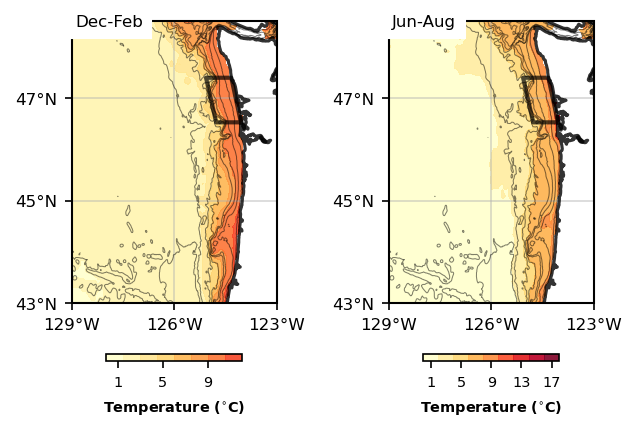

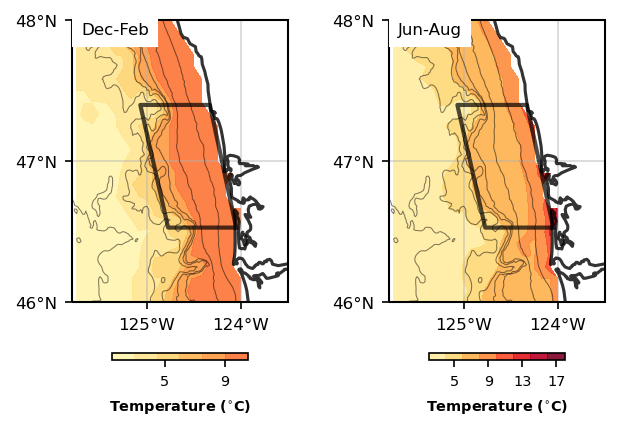

Temperature, surface


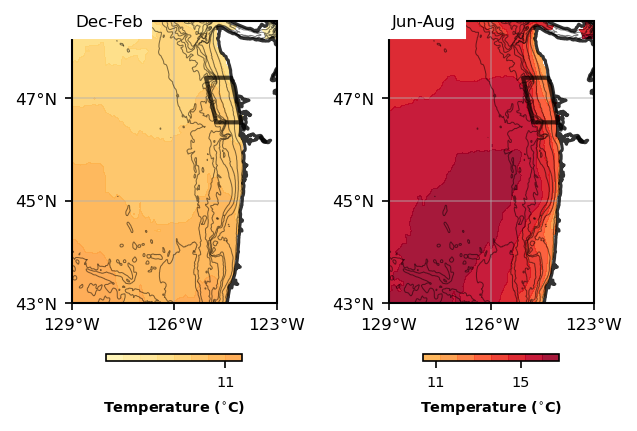

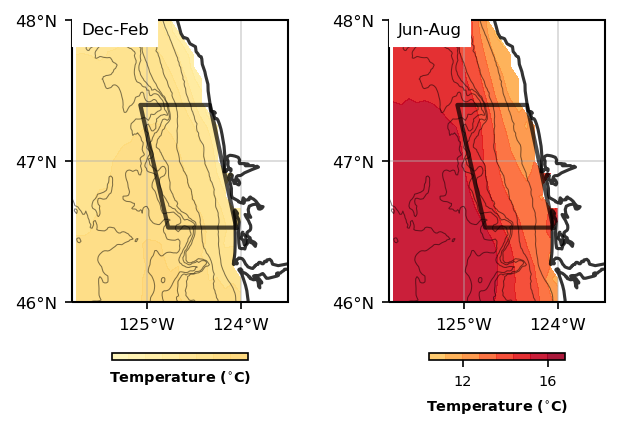

DO, bottom


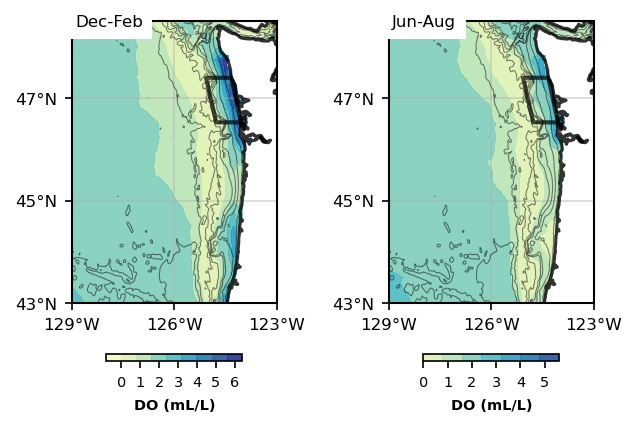

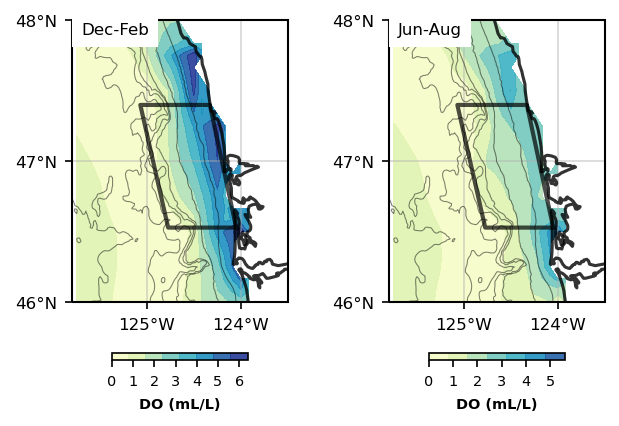

DO, surface


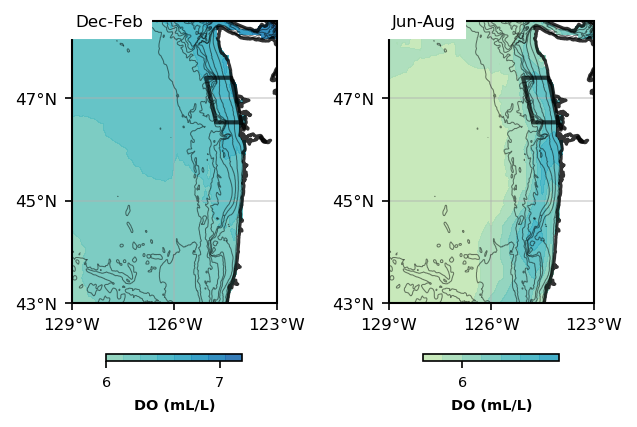

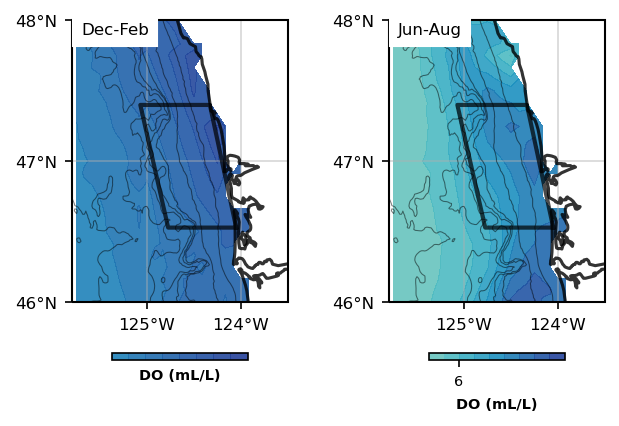

In [49]:
# DJF, JJA both seasons averages 
for i in range(4):
    if i==0:
        print('Temperature, bottom')
        fn = ldp+'QIN/downscaled_data/ssp585/thetao/bottom/UKESM1-0-LL_r1i1p1f2_sd+ba_final_thetao_bottom_depth_None_subset.nc'
        tit = 'Temperature ($^{\circ}$C)'
        var = 'thetao'
    elif i==1:
        print('Temperature, surface')
        fn = ldp+'QIN/downscaled_data/ssp585/thetao/surface/UKESM1-0-LL_r1i1p1f2_sd+ba_final_thetao_surface_depth_5_subset.nc'
        tit = 'Temperature ($^{\circ}$C)'
        var = 'thetao'
    elif i==2:
        print('DO, bottom')
        fn = ldp+'QIN/downscaled_data/ssp585/o2/bottom/UKESM1-0-LL_r1i1p1f2_sd+ba_final_o2_bottom_depth_None_subset.nc'
        tit = 'DO (mL/L)'
        var = 'o2'
    else:
        print('DO, surface')
        fn = ldp+'QIN/downscaled_data/ssp585/o2/surface/UKESM1-0-LL_r1i1p1f2_sd+ba_final_o2_surface_depth_5_subset.nc'
        tit = 'DO (mL/L)'
        var = 'o2'
        
    ds = xr.open_dataset(fn)
    ds.close()
    ds.coords['lon'] = np.mod(ds.coords['lon'] + 180,360) - 180
    ds_present = ds[var].sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]),time=slice('2010-01-01','2019-12-31')).groupby('time.season').mean()
    ds_present = ds_present.where(ds_present.season!='MAM',drop=True)
    ds_present = ds_present.where(ds_present.season!='SON',drop=True)
    
    make_map(ds_present, ldom, var, tit)

    ds_present = ds_present.sel(lat=slice(lqin[0,0],lqin[0,1]),lon=slice(lqin[1,0],lqin[1,1]))

    make_map(ds_present, ldom_qin, var, tit)


 **  Sablefish  **
Temperature, bottom


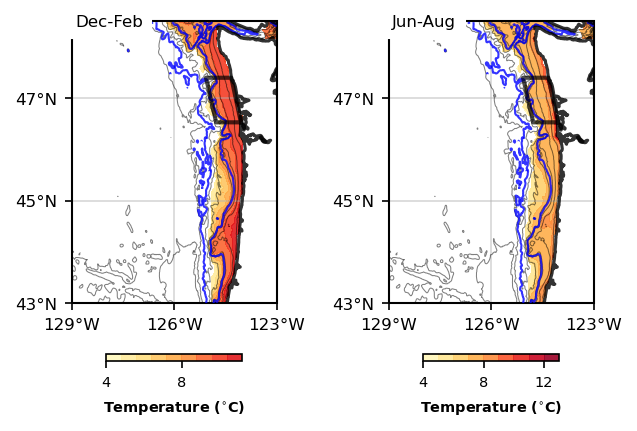

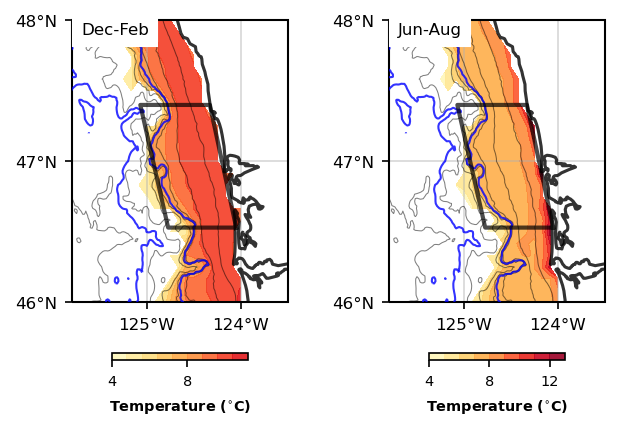


 **  Sablefish  **
Temperature, surface


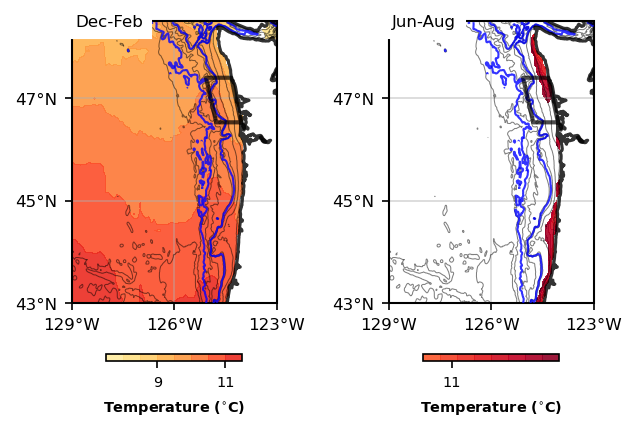

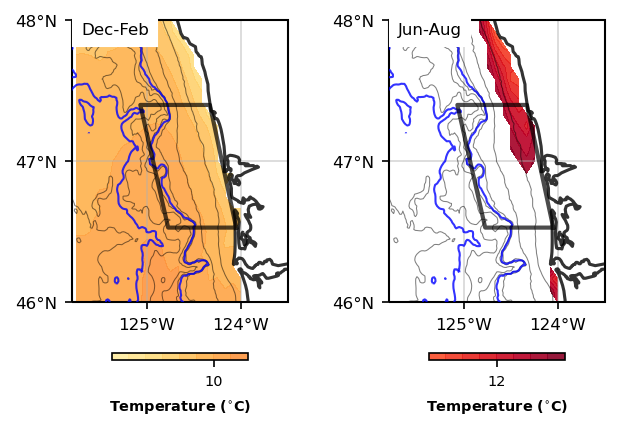


 **  Sablefish  **
DO, bottom


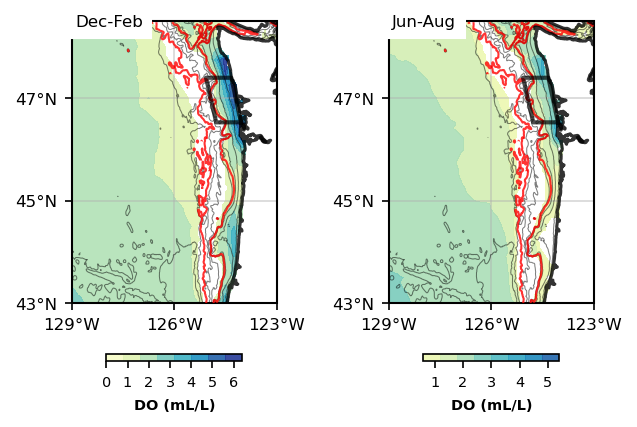

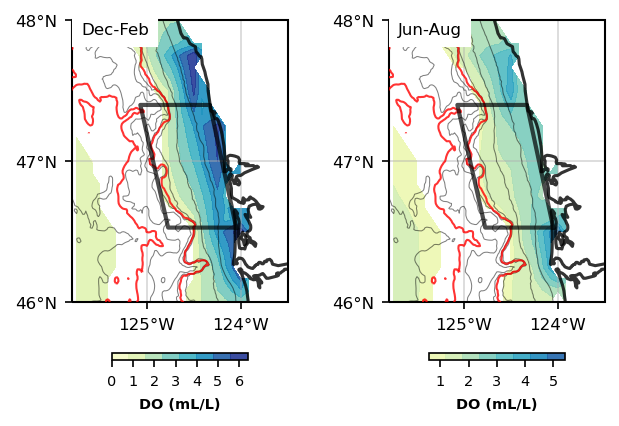


 **  Sablefish  **
DO, surface


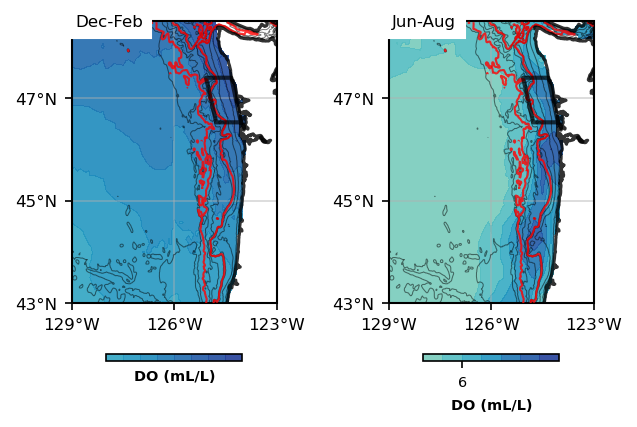

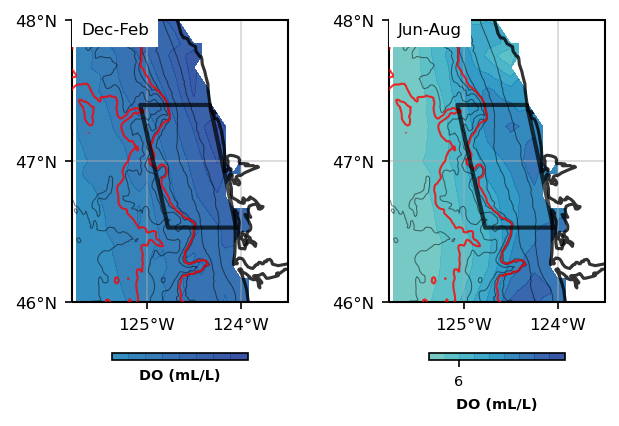


 **  Dungeness Crab  **
Temperature, bottom


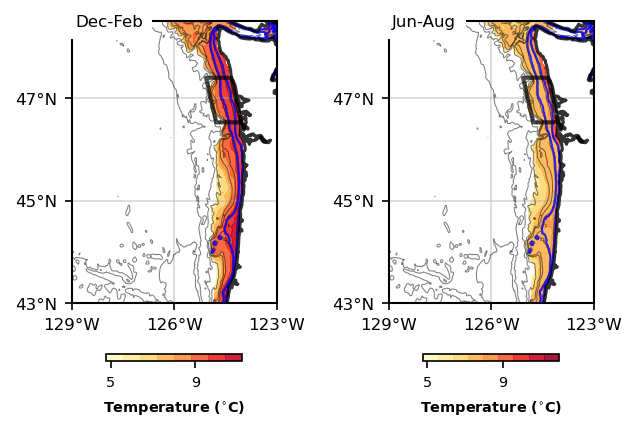

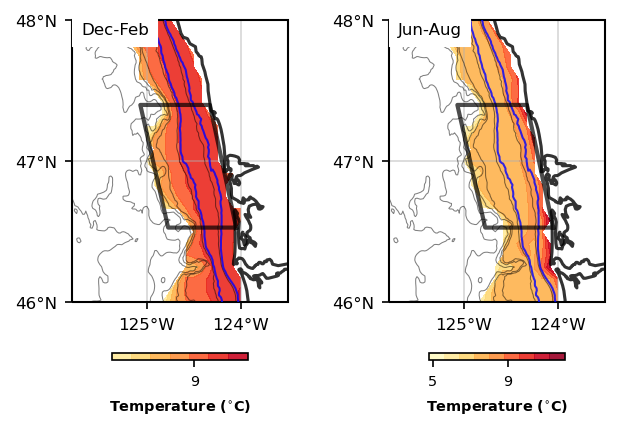


 **  Dungeness Crab  **
Temperature, surface


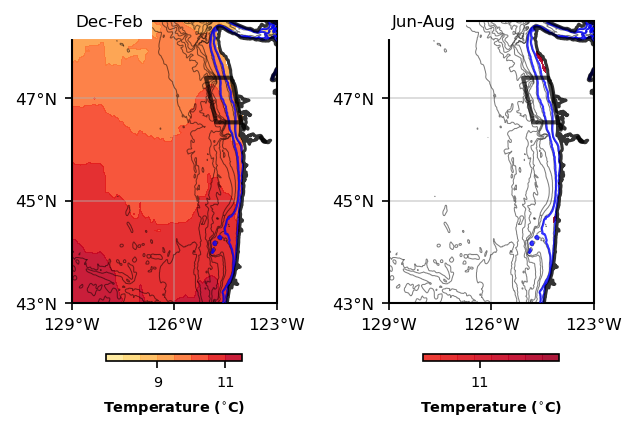

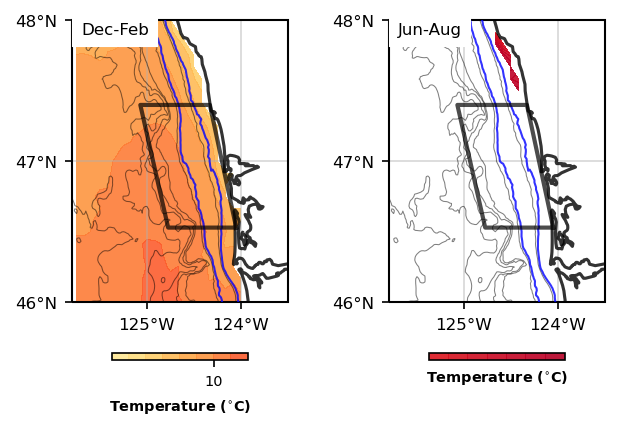


 **  Dungeness Crab  **
DO, bottom


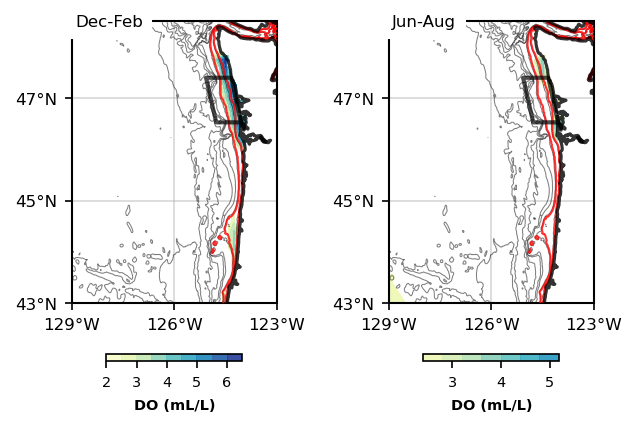

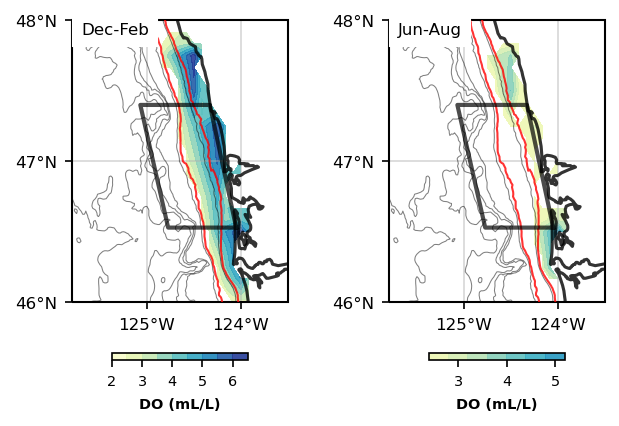


 **  Dungeness Crab  **
DO, surface


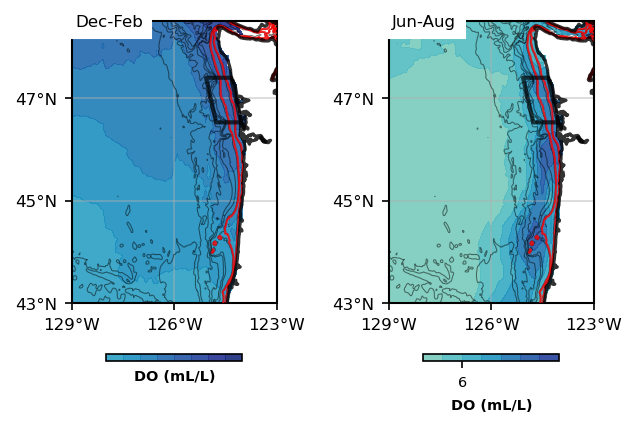

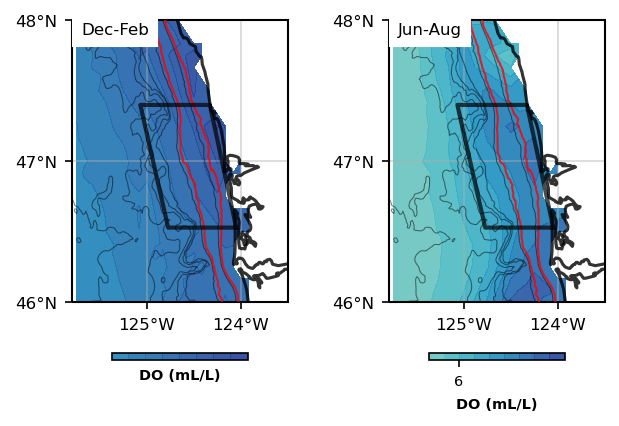


 **  Hake  **
Temperature, bottom


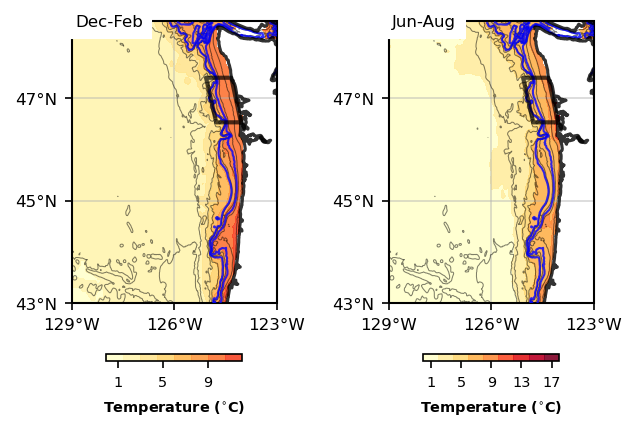

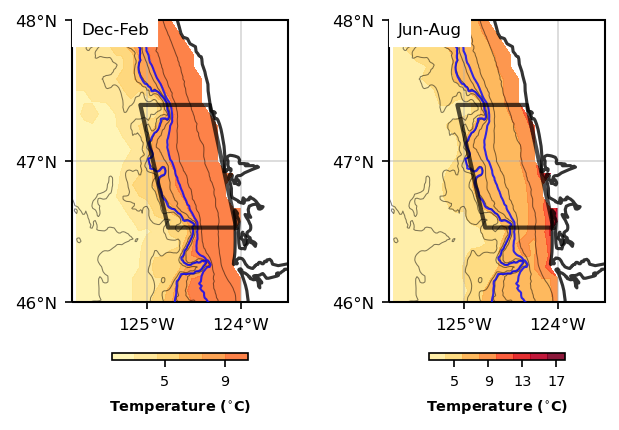


 **  Hake  **
Temperature, surface


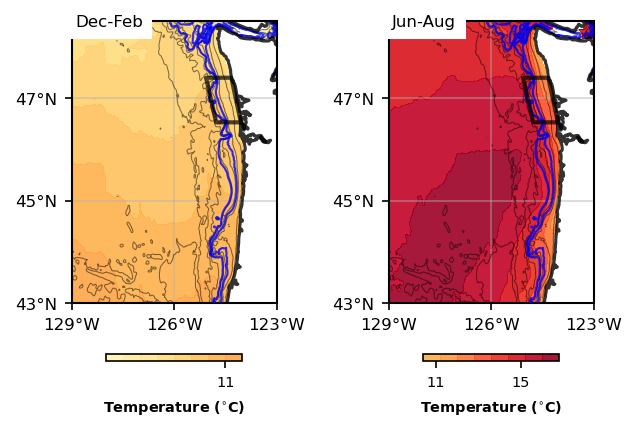

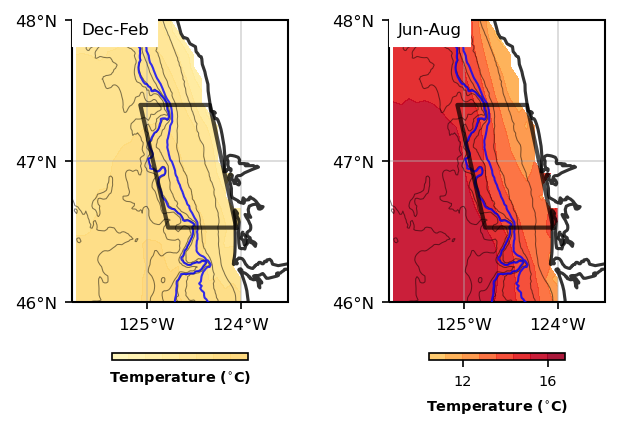


 **  Hake  **
DO, bottom


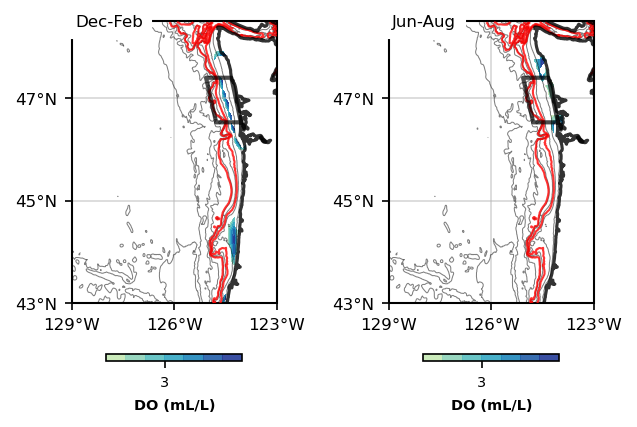

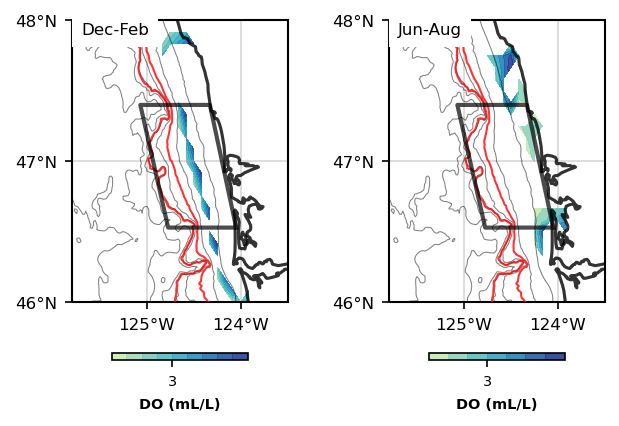


 **  Hake  **
DO, surface


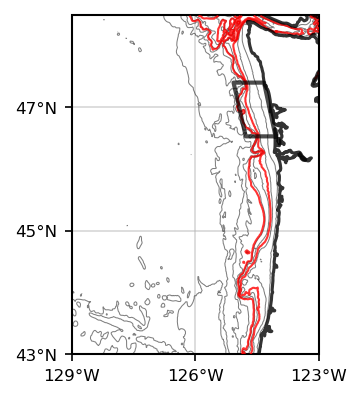


No suitable habitat


 **  Lingcod  **
Temperature, bottom


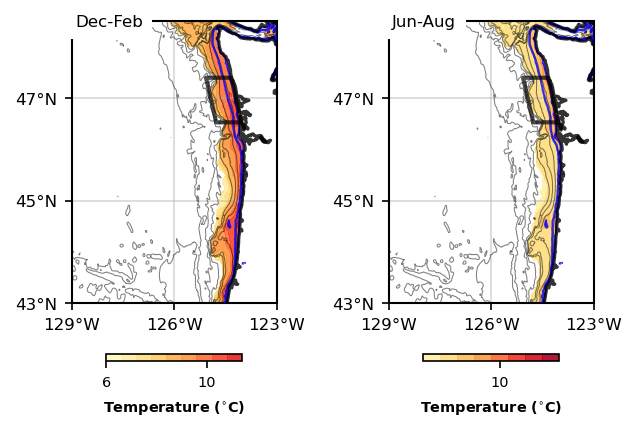

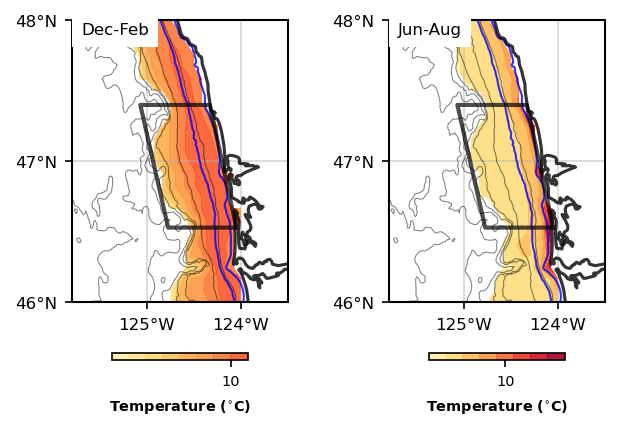


 **  Lingcod  **
Temperature, surface


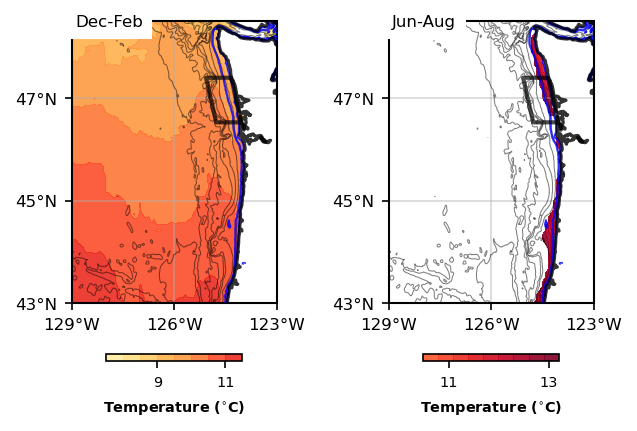

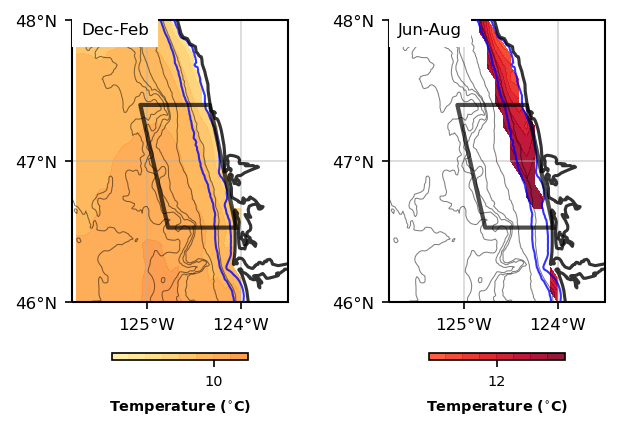


 **  Lingcod  **
DO, bottom


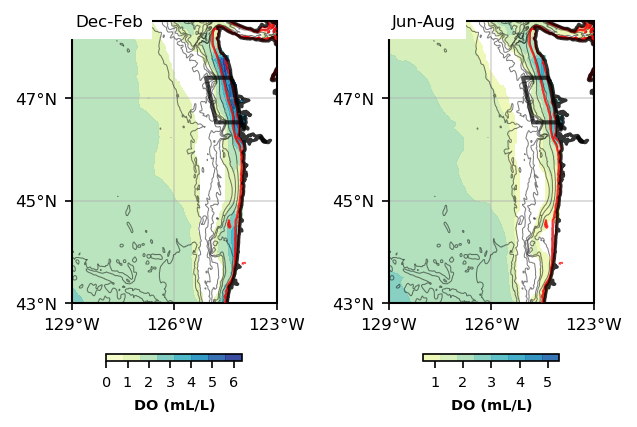

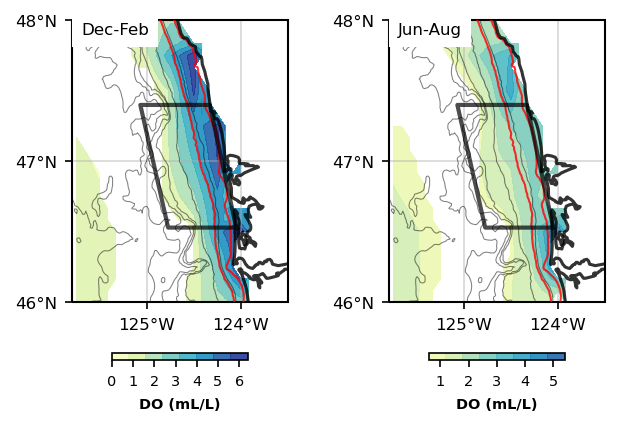


 **  Lingcod  **
DO, surface


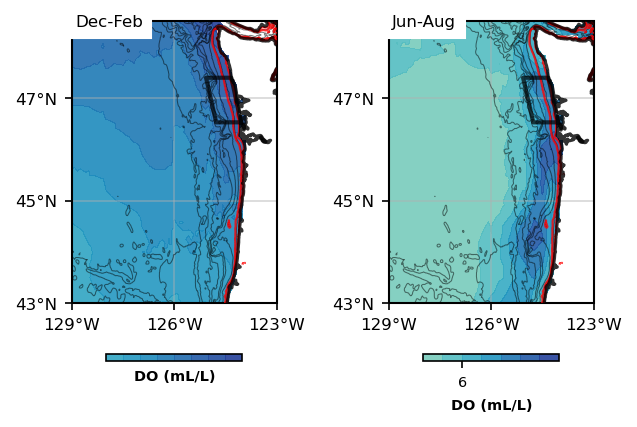

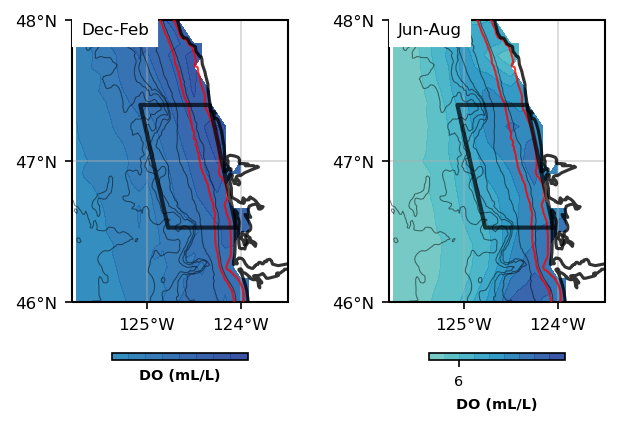


 **  P. Halibut  **
Temperature, bottom


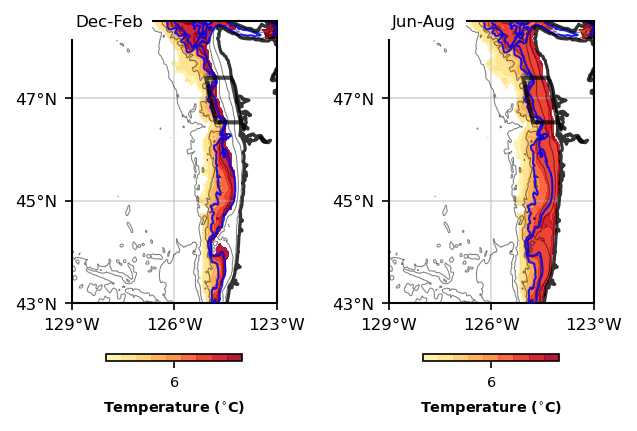

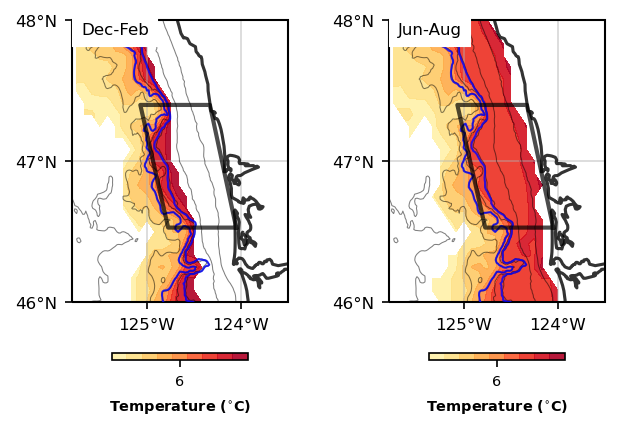


 **  P. Halibut  **
Temperature, surface


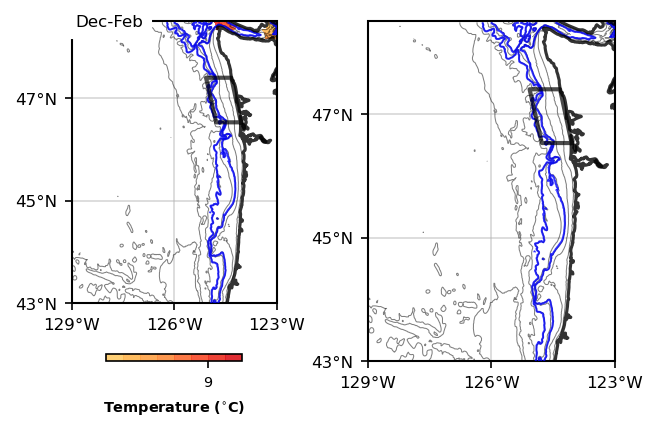


No suitable habitat


 **  P. Halibut  **
DO, bottom


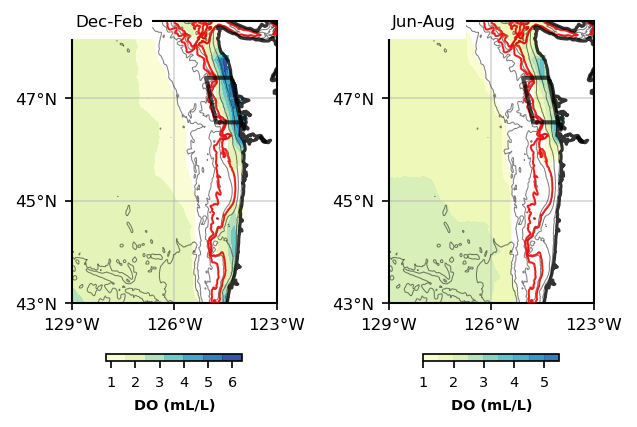

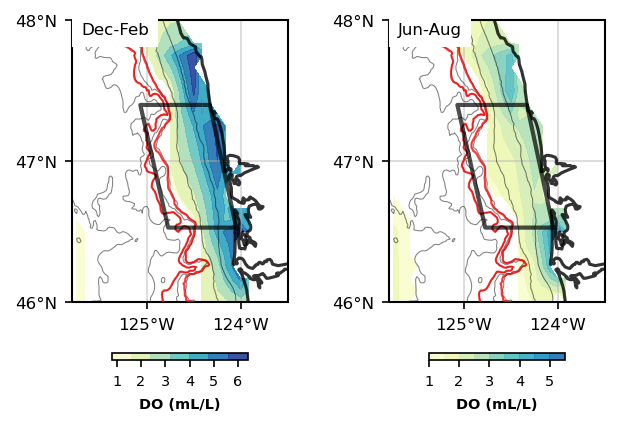


 **  P. Halibut  **
DO, surface


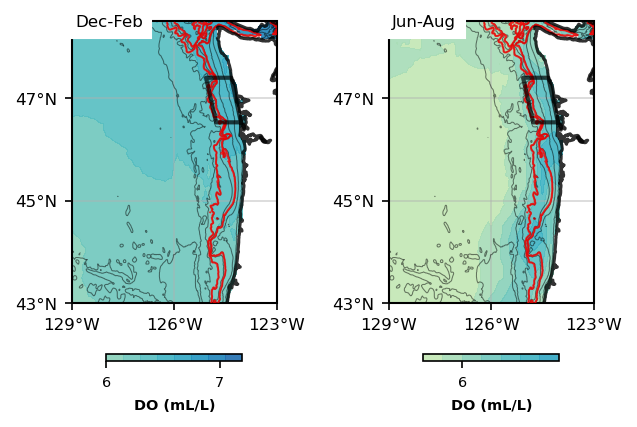

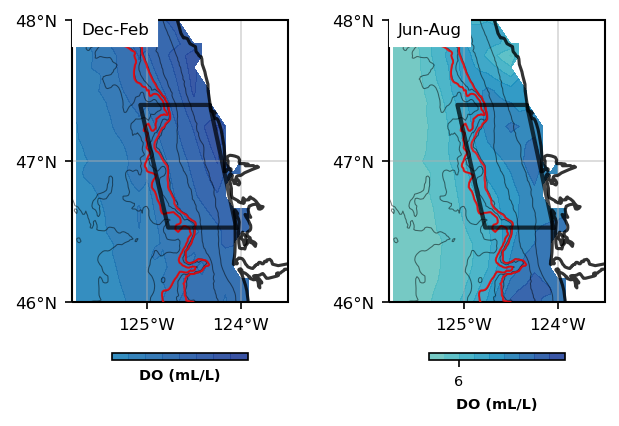


 **  Chinook  **
Temperature, bottom


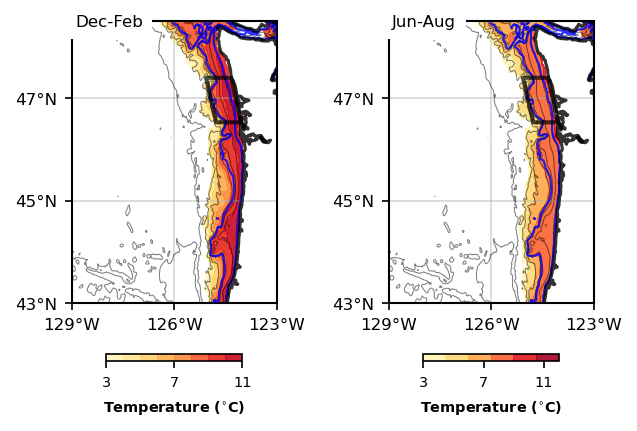

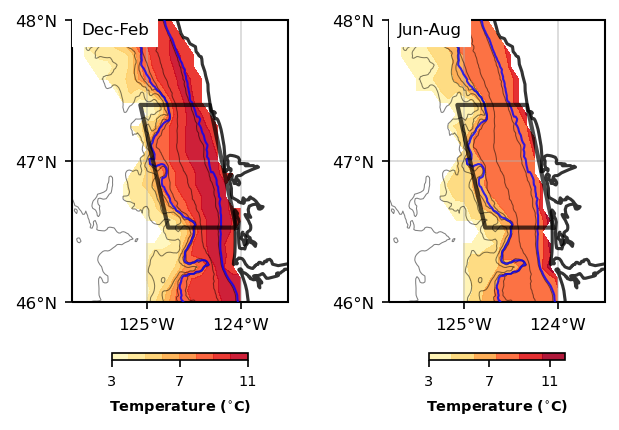


 **  Chinook  **
Temperature, surface


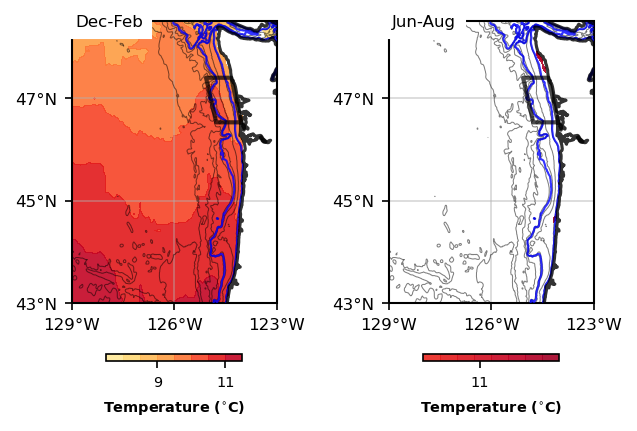

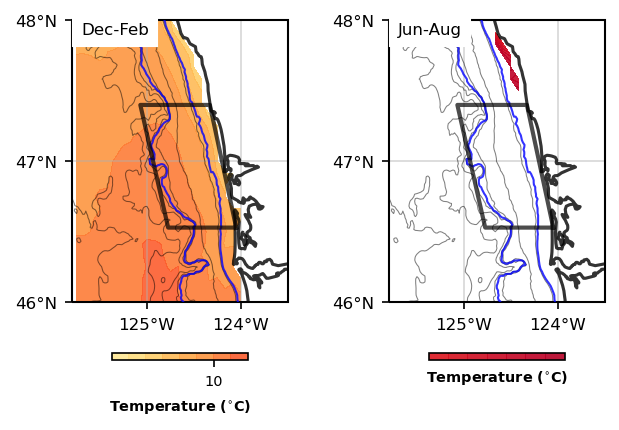


 **  Chinook  **
DO, bottom


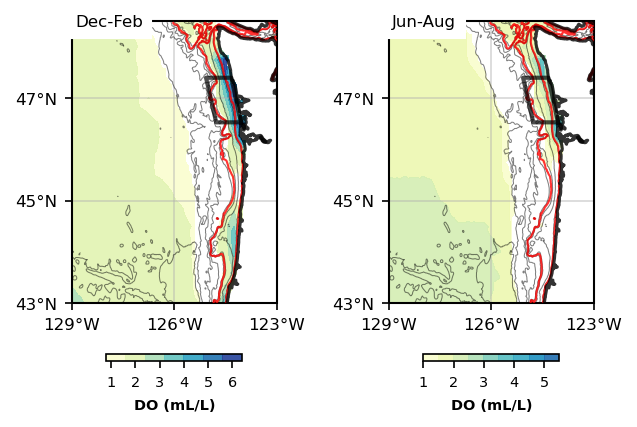

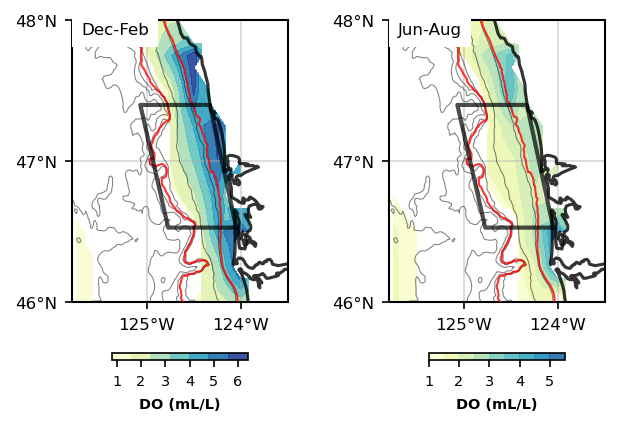


 **  Chinook  **
DO, surface


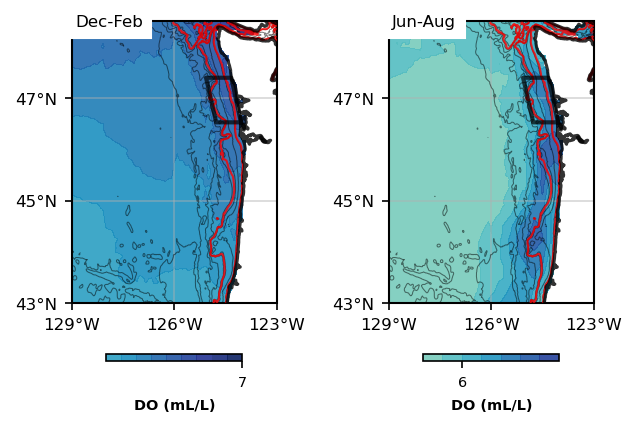

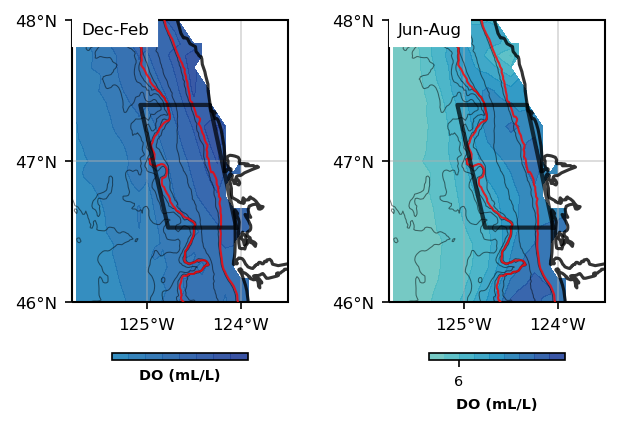


 **  Coho  **
Temperature, bottom


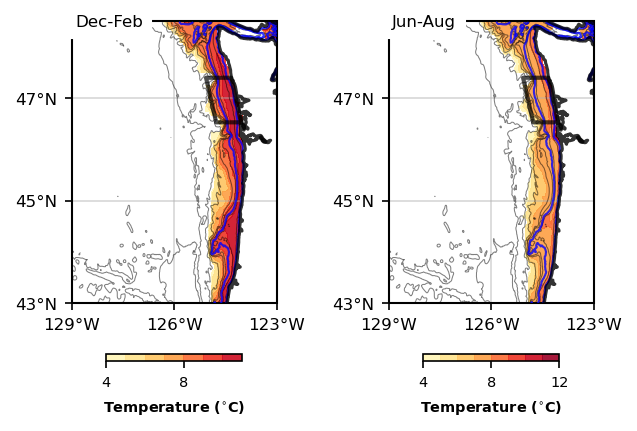

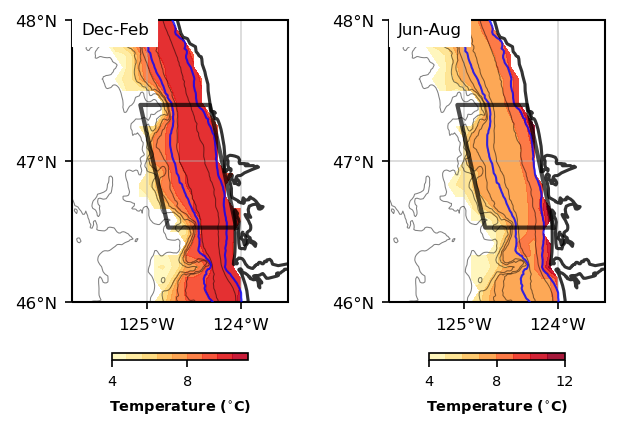


 **  Coho  **
Temperature, surface


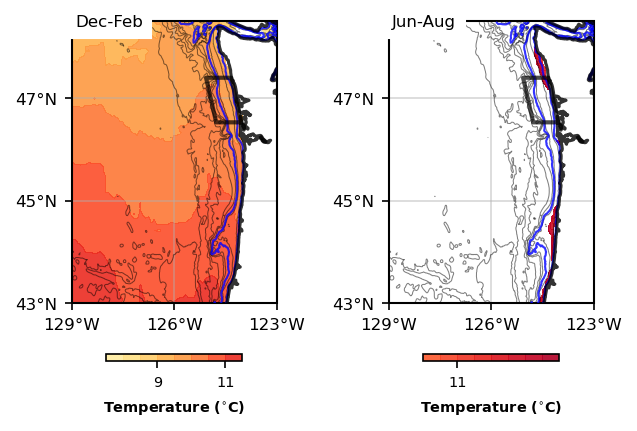

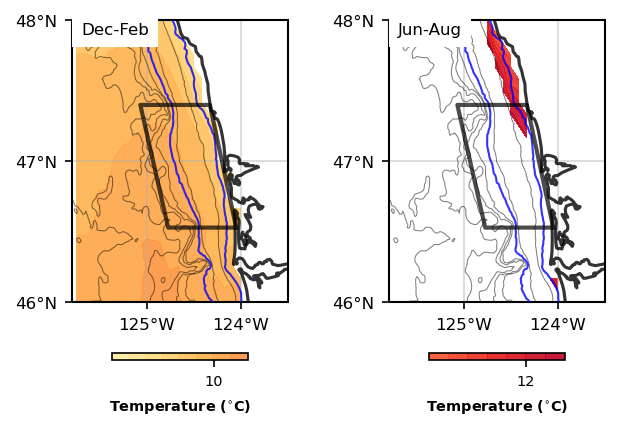


 **  Coho  **
DO, bottom


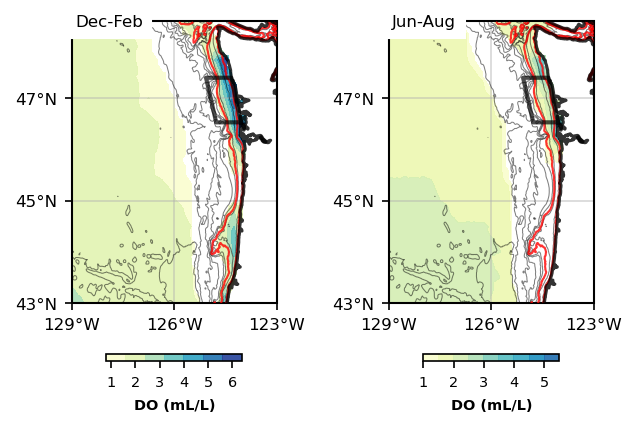

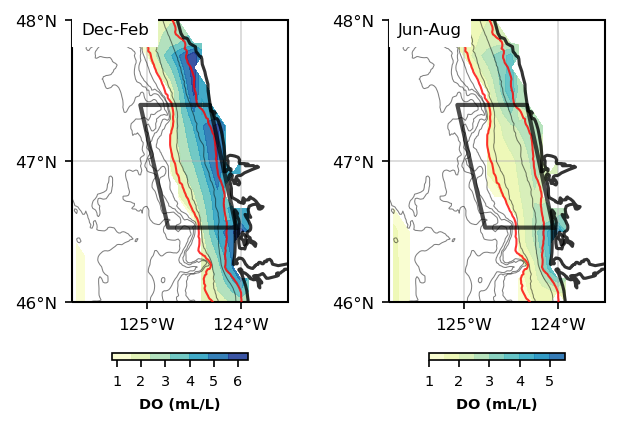


 **  Coho  **
DO, surface


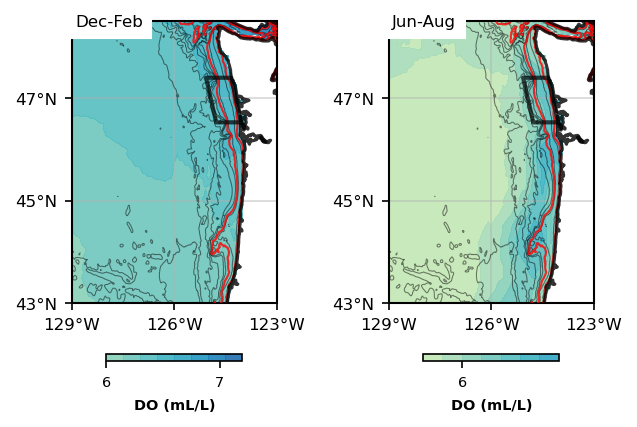

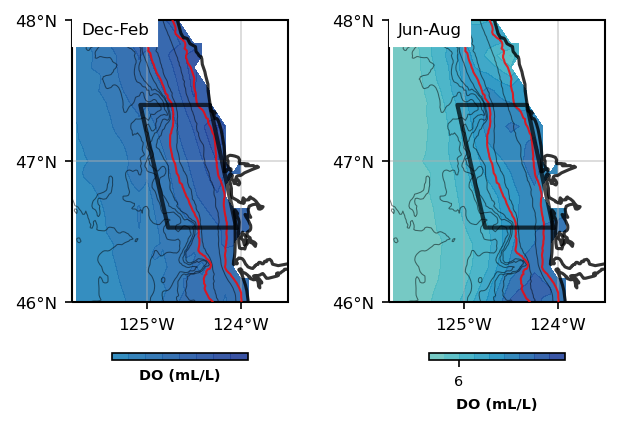


 **  Steelhead  **
Temperature, bottom


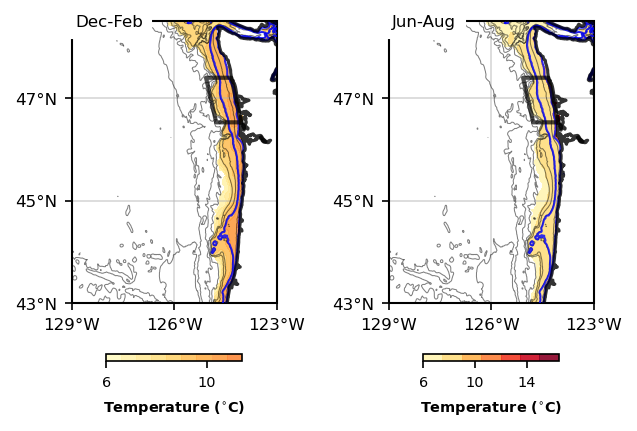

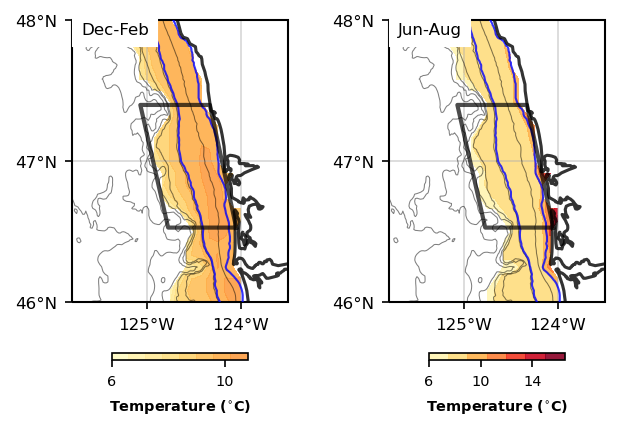


 **  Steelhead  **
Temperature, surface


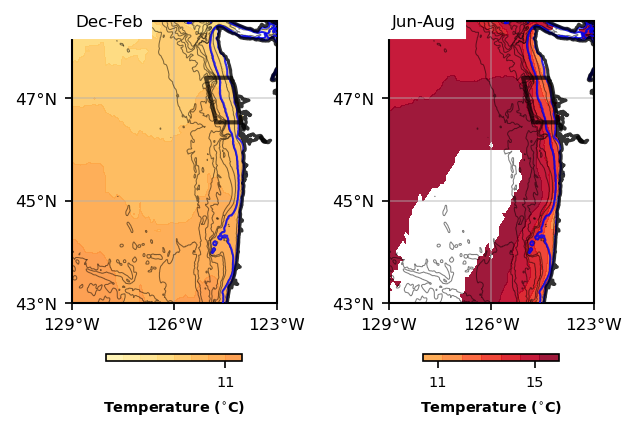

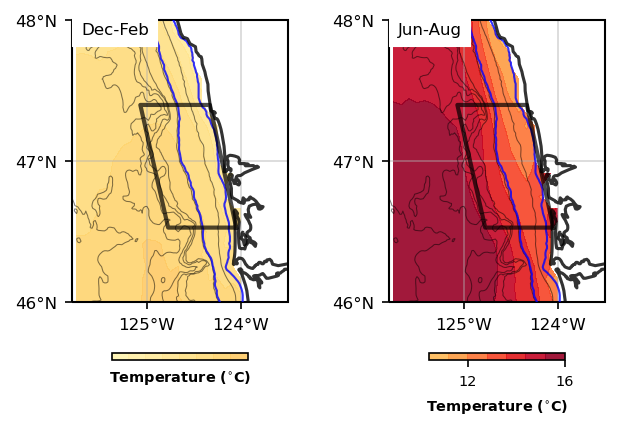


 **  Steelhead  **
DO, bottom


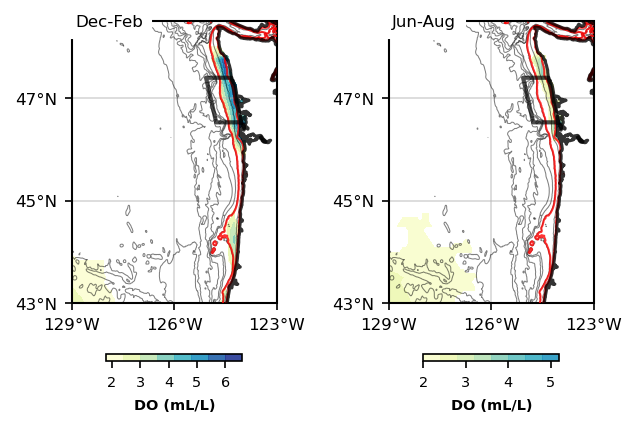

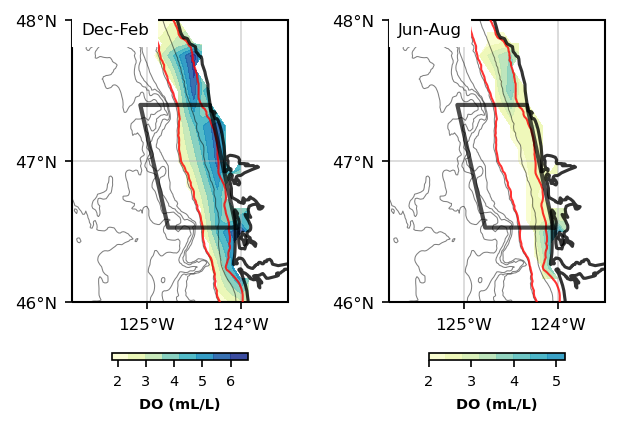


 **  Steelhead  **
DO, surface


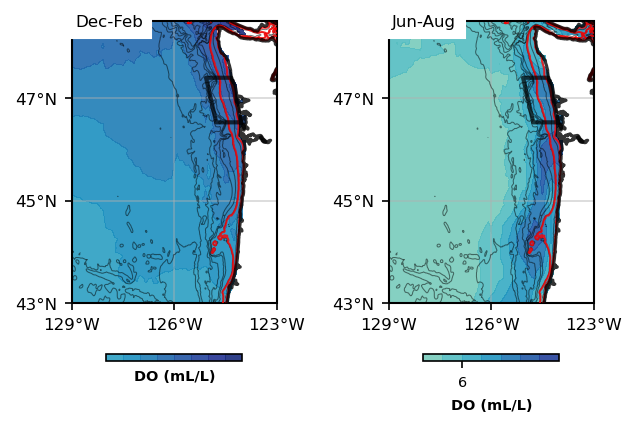

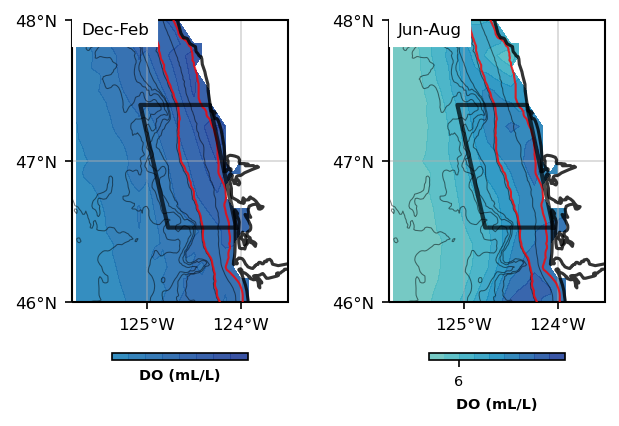

In [60]:
# DJF, JJA both seasons averages 
for jx, j in enumerate(fishes):
    for i in range(4):
        print('\n ** ',j,' **')
        if i==0:
            print('Temperature, bottom')
            fn = ldp+'QIN/downscaled_data/ssp585/thetao/bottom/UKESM1-0-LL_r1i1p1f2_sd+ba_final_thetao_bottom_depth_None_subset.nc'
            tit = 'Temperature ($^{\circ}$C)'
            var = 'thetao'
        elif i==1:
            print('Temperature, surface')
            fn = ldp+'QIN/downscaled_data/ssp585/thetao/surface/UKESM1-0-LL_r1i1p1f2_sd+ba_final_thetao_surface_depth_5_subset.nc'
            tit = 'Temperature ($^{\circ}$C)'
            var = 'thetao'
        elif i==2:
            print('DO, bottom')
            fn = ldp+'QIN/downscaled_data/ssp585/o2/bottom/UKESM1-0-LL_r1i1p1f2_sd+ba_final_o2_bottom_depth_None_subset.nc'
            tit = 'DO (mL/L)'
            var = 'o2'
        else:
            print('DO, surface')
            fn = ldp+'QIN/downscaled_data/ssp585/o2/surface/UKESM1-0-LL_r1i1p1f2_sd+ba_final_o2_surface_depth_5_subset.nc'
            tit = 'DO (mL/L)'
            var = 'o2'

        ds = xr.open_dataset(fn)
        ds.close()
        ds.coords['lon'] = np.mod(ds.coords['lon'] + 180,360) - 180
        ds_present = ds[var].sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]),time=slice('2010-01-01','2019-12-31')).groupby('time.season').mean()
        ds_present = ds_present.where(ds_present.season!='MAM',drop=True)
        ds_present = ds_present.where(ds_present.season!='SON',drop=True)

        # # suitable habitat
        if var == 'thetao':
            th1, th2 = Trange[jx,0], Trange[jx,1]
        else:
            th1, th2 = O2range[jx,0], O2range[jx,1]

        ds_present = ds_present.where((ds_present>=th1)&(ds_present<=th2), np.nan)

        d1,d2 = Deprange[jx,0], Deprange[jx,1]
        
        try:
            make_map(ds_present, ldom, var, tit, True, d1, d2)

            ds_present = ds_present.sel(lat=slice(lqin[0,0],lqin[0,1]),lon=slice(lqin[1,0],lqin[1,1]))

            make_map(ds_present, ldom_qin, var, tit, True, d1, d2)
        except:
            plt.show()
            print('\nNo suitable habitat\n')


In [55]:
fishes[0]

'Sablefish'